#### Some preparations

In [2]:
!unzip -qq laba-dataset.zip

In [3]:
!rm -rf samples/samples

In [4]:
!ls samples | wc -w

1070


In [6]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
from torchmetrics import CharErrorRate
import torch.nn as nn
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchinfo import summary

In [34]:
IMAGE_FOLDER = './samples'
BATCH_SIZE = 64
N_EPOCHS = 75
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
IS_CUDA = DEVICE != 'cpu'

In [8]:
DEVICE

'cuda:0'

### Dataset class

In [9]:
from torchvision import transforms

In [64]:
class CaptchaDataset(Dataset):
    BLANK_TOKEN = '#'

    def __init__(self, image_folder, image_transformer=None):
        self.image_folder = image_folder
        self.image_files = os.listdir(image_folder)
        self.labels = [file.split('.')[0] for file in self.image_files]
        self.image_transformer = image_transformer
        self.to_tensor_tf = transforms.ToTensor()
        self._get_token_map()
        self._read_all_images()
        self.encoded_labeles = self.encode(self.labels)

    def _get_token_map(self):
        tokens = set(''.join(self.labels))
        self.tokens = sorted(tokens)
        self.id_to_token = {0: self.BLANK_TOKEN}
        for index, token in enumerate(self.tokens):
            self.id_to_token[index + 1] = token
        self.token_to_id = {self.BLANK_TOKEN: 0}
        for index, token in enumerate(self.tokens):
            self.token_to_id[token] = index + 1

    def _read_all_images(self):
        self.images = {}
        for path in self.image_files:
            image_path = os.path.join(self.image_folder, path)
            x = Image.open(image_path)
            x = self.to_tensor_tf(x)
            if x.shape[0] == 4:
                x = x[:3]
            self.images[path] = x

    def __getitem__(self, index):
        x = self.images[self.image_files[index]]
        if self.image_transformer:
            x = self.image_transformer(x)
        encoded_label = self.encoded_labeles[index]
        label = self.labels[index]
        return (x, encoded_label, label, encoded_label.shape[0])

    def __len__(self):
        return len(self.image_files)

    def num_tokens(self):
        return len(self.tokens) + 1

    def encode(self, sequences, max_len=None):
        sequences_idx = [
            torch.LongTensor([self.token_to_id[char] for char in sequence])
            for sequence in sequences
        ]
        return nn.utils.rnn.pad_sequence(
            sequences=sequences_idx, 
            batch_first=True,
            padding_value=0
        ).long()

    def decode(self, indexes):
        def make_label_from_ids(ids):
            tokens = []
            last_idx = -1
            for id_ in ids:
                token = self.id_to_token[id_.item()]
                if token == self.BLANK_TOKEN:
                    last_idx = -1
                    continue
                tokens.append(token)
                last_idx = id_
            return ''.join(tokens)
        return list(map(make_label_from_ids, indexes))

#### Check dataset class

In [65]:
dataset = CaptchaDataset(IMAGE_FOLDER)

In [66]:
dataset.encoded_labeles[0]

tensor([11,  1, 14, 13,  1])

In [67]:
dataset.decode([torch.LongTensor([ 4,  6,  2,  8, 15]), torch.LongTensor([ 4,  6,  2,  1, 0])])

['573bn', '5732']

In [68]:
torch.LongTensor([ 4,  6,  2,  8, 15])

tensor([ 4,  6,  2,  8, 15])

In [69]:
dataset.images['ygce8.jpg'].shape

torch.Size([3, 50, 200])

### Model (CNN + Bi-LSTM)

In [70]:
class Model(nn.Module):
    def __init__(self, n_classes, channel_num=3):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(
                in_channels=channel_num,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, 
            ),

            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2, 
            ),

            nn.Conv2d(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 3), 
            ),

            nn.Conv2d(
                in_channels=256,
                out_channels=512,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=(2, 3), 
            ),

        )

        self.linear = nn.Sequential(
            nn.Linear(
                in_features=1536, 
                out_features=256
            )
        )

        self.lstm = nn.LSTM(256, 64, 2, bidirectional=True, batch_first=True, dropout=0.3)
        self.out_layer = nn.Linear(128, n_classes)
    
    def forward(self, input):
        from_conv = self.conv_layers(input)
        from_conv = from_conv.permute(0, 3, 1, 2)
        from_conv = from_conv.view(from_conv.size(0), from_conv.size(1), -1)
        from_linear = self.linear(from_conv)
        from_lstm, _ = self.lstm(from_linear)
        output = self.out_layer(from_lstm)
        return output.permute(0, 2, 1)

Model output is obtained by [batch, dict_size, num_chars_in_output] - [batch, 20, 5]. 

In [76]:
summary(Model(20), input_size=(BATCH_SIZE, 3, 50, 200))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [64, 20, 5]               --
├─Sequential: 1-1                        [64, 512, 3, 5]           --
│    └─Conv2d: 2-1                       [64, 64, 50, 200]         1,792
│    └─BatchNorm2d: 2-2                  [64, 64, 50, 200]         128
│    └─ReLU: 2-3                         [64, 64, 50, 200]         --
│    └─MaxPool2d: 2-4                    [64, 64, 25, 100]         --
│    └─Conv2d: 2-5                       [64, 128, 25, 100]        73,856
│    └─BatchNorm2d: 2-6                  [64, 128, 25, 100]        256
│    └─ReLU: 2-7                         [64, 128, 25, 100]        --
│    └─MaxPool2d: 2-8                    [64, 128, 12, 50]         --
│    └─Conv2d: 2-9                       [64, 256, 12, 50]         295,168
│    └─BatchNorm2d: 2-10                 [64, 256, 12, 50]         512
│    └─ReLU: 2-11                        [64, 256, 12, 50]         --


In [77]:
print(model)

Model(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0,

### Training

In [78]:
model = Model(dataset.num_tokens(), channel_num=3).to(device=DEVICE)
opt = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3, cooldown=2, min_lr=1e-7)
loss_func = nn.CrossEntropyLoss()
metric = CharErrorRate()

Image mean and std is from ImageNet

In [79]:
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

transformer = transforms.Compose([
    transforms.Normalize(image_mean, image_std)
])

In [80]:
dataset = CaptchaDataset(image_folder=IMAGE_FOLDER, image_transformer=transformer)

In [81]:
test_ratio = 0.25
test_size = int(test_ratio * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [len(dataset) - test_size, test_size]) 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=IS_CUDA)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=IS_CUDA)

In [82]:
from IPython.display import clear_output
from tqdm import tqdm

In [83]:
def train_loop(model, loss_func, opt, scheduler, n_epoch, train_loader, test_loader, device):
    plt.ion()
    
    train_history = []
    test_history = []
    for i in tqdm(range(n_epoch), position=0):
        epoch_loss = []
        for batch_imgs, labels, _, captchas_lengths in tqdm(
            train_loader, position=1, desc='train', leave=False
        ):
            opt.zero_grad()

            labels_d = labels.to(device)
            logits = model(batch_imgs.to(device)).to(device)
            loss = loss_func(logits, labels_d)

            loss.backward()
            opt.step()
            epoch_loss.append(loss.item())

        train_history.append(np.mean(epoch_loss))

        with torch.no_grad():
            test_losses = []
            for batch_imgs, labels, _, captchas_lengths in tqdm(
                test_loader, position=2, desc='test', leave=False
            ):
                labels_d = labels.to(device)
                logits = model(batch_imgs.to(device)).to(device)
                loss = loss_func(logits, labels_d)
                test_losses.append(loss.item())

            test_history.append(np.mean(test_losses))

        scheduler.step(test_history[-1])

        clear_output(wait=True)
        plt.plot(train_history, label='Train')
        plt.plot(test_history, label='Test')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    assert np.mean(train_history[:10]) > np.mean(train_history[-10:]), "Model didn't converge."
    print(f'Final Train Loss: {train_history[-1]}')
    print(f'Final Test Loss: {test_history[-1]}')

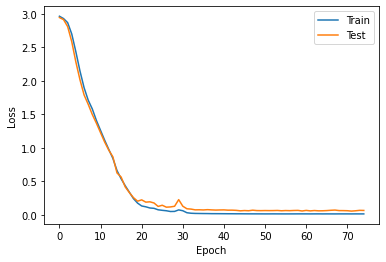

100%|██████████| 75/75 [01:55<00:00,  1.54s/it]

Final Train Loss: 0.016885328822984144
Final Test Loss: 0.0683273807168007


In [84]:
train_loop(
    model=model, loss_func=loss_func, opt=opt,
    scheduler=scheduler,
    n_epoch=N_EPOCHS,
    train_loader=train_loader,
    test_loader=test_loader,
    device=DEVICE
)

### Model evaluating

In [122]:
def from_logits_to_chars(logits, loader):
    preds = logits.argmax(1).detach().cpu().numpy()
    chars = loader.dataset.dataset.decode(preds)
    return chars

In [140]:
@torch.no_grad()
def eval_model(model, loader, device):
    batch_errors = []
    for batch_imgs, _, batch_captchas, _ in loader:
        logits = model(batch_imgs.to(device))
        captchas_pred = from_logits_to_chars(logits, loader)
        batch_errors.append(metric(batch_captchas, captchas_pred))
    return np.mean(batch_errors)

In [141]:
eval_model(model, train_loader, DEVICE)

0.00024038462

In [142]:
eval_model(model, test_loader, DEVICE)

0.016761363

### Saving model

In [89]:
path_to_save = 'captcha_rec.pkl'
torch.save(
    {
        'model': model.state_dict(),
        'optimizer': opt.state_dict(),
        'scheduler': scheduler.state_dict(),
    },
    path_to_save
)

### Error analysing

On test data CER is 1.6%

In [103]:
@torch.no_grad()
def analyze_errors(model, loader, device):
    batch_errors = []
    for batch_imgs, _, batch_captchas, _ in loader:
        logits = model(batch_imgs.to(device))
        captchas_pred = from_logits_to_chars(logits, loader)

        pred_errors = [metric(b_c, c_p) for b_c, c_p in zip(batch_captchas, captchas_pred)]
        max_erros_indices = np.argwhere(np.array(pred_errors) > 0).flatten()
        batch_imgs_errors = batch_imgs[max_erros_indices]
        batch_captchas_errors = [batch_captchas[i] for i in max_erros_indices]
        captchas_pred_errors = [captchas_pred[i] for i in max_erros_indices]

        batch_errors.append((batch_imgs_errors, batch_captchas_errors, captchas_pred_errors))
    return batch_errors

In [104]:
train_errors = analyze_errors(model, train_loader, DEVICE)

Captcha - mmc5n. Predicted - mmp5n


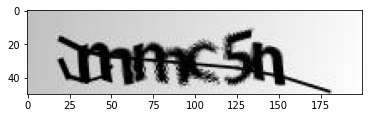

In [117]:
for imgs, captions, captions_pred in train_errors:
    for i in range(len(captions)):
        print(f"Captcha - {captions[i]}. Predicted - {captions_pred[i]}")
        plt.imshow(Image.open(IMAGE_FOLDER + '/' + captions[i] + '.png'), cmap='gray')
        plt.show()

In [118]:
test_errors = analyze_errors(model, test_loader, DEVICE)

Captcha - mdyp7. Predicted - mbyp7


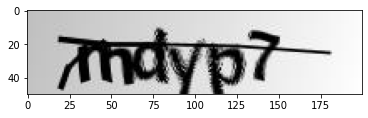

Captcha - f35xp. Predicted - f35cb


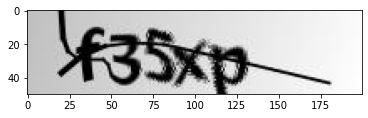

Captcha - 25257. Predicted - 2527f


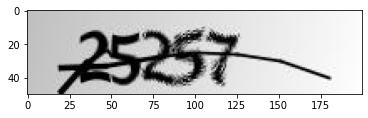

Captcha - men4f. Predicted - mcn4f


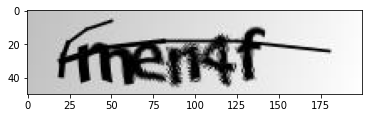

Captcha - 3c7de. Predicted - 3c5de


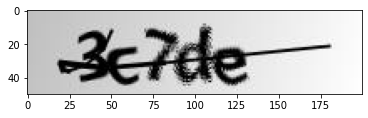

Captcha - mx8bb. Predicted - mx8db


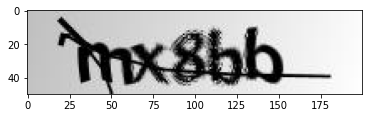

Captcha - bwmee. Predicted - bwmwe


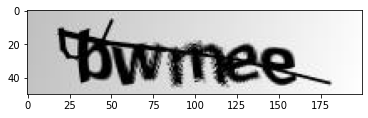

Captcha - 5nggg. Predicted - 5mggg


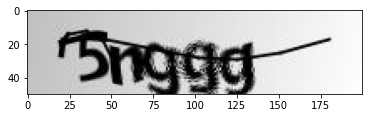

Captcha - w2yp7. Predicted - w3xp7


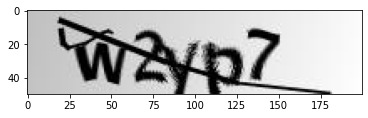

Captcha - 34fxm. Predicted - 34fmm


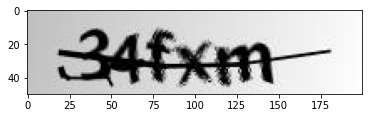

Captcha - wm47f. Predicted - wmm7f


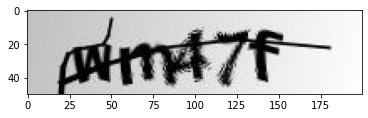

Captcha - nm248. Predicted - nm288


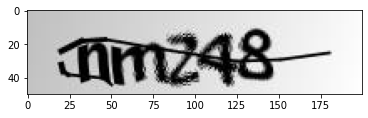

Captcha - nf2n8. Predicted - mf2n8


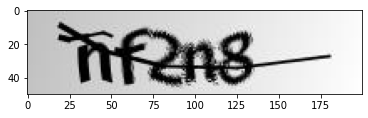

Captcha - ndg2b. Predicted - ndg2n


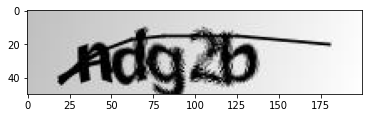

Captcha - mmg2m. Predicted - mmg2n


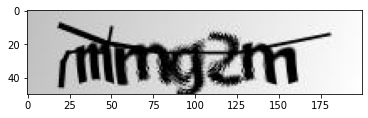

Captcha - pf5ng. Predicted - pf5np


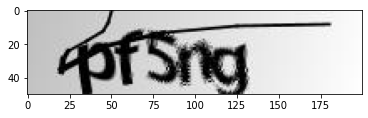

Captcha - 77n6g. Predicted - 77n6p


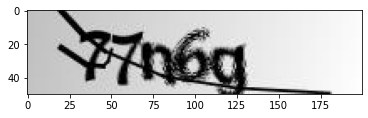

Captcha - 4w6mw. Predicted - 4w6ww


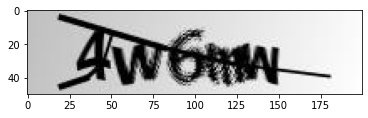

Captcha - mc8w2. Predicted - mc842


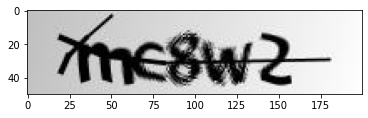

Captcha - pm363. Predicted - pn363


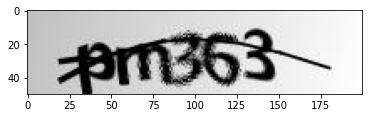

In [121]:
for imgs, captions, captions_pred in test_errors:
    for i in range(len(captions)):
        print(f"Captcha - {captions[i]}. Predicted - {captions_pred[i]}")
        try:
            plt.imshow(Image.open(IMAGE_FOLDER + '/' + captions[i] + '.png'), cmap='gray')
        except FileNotFoundError:
            plt.imshow(Image.open(IMAGE_FOLDER + '/' + captions[i] + '.jpg'), cmap='gray')
        plt.show()

Most mistakes are due to confusing similar letters in distorted places - m and n, b and d, p and g. Most likely this can be corrected by increasing the training sample (now the test size is 25%), and you can also expand the dataset by adding distortions to some pictures (rotation, blurring, extra lines as noise). 